## **TP réalisé par** :
- Kpodjro KPATOUKPA
- Orchelle Patricia WELEHELA TAWEUTEU

# **Etape 2. Constraint-based method (PC)**

## **2.1 Reconstruction du réseau avec PC (pcalg::pc)**
Pour cette étape, nous allons procéder comme suit :
* Convertir les données en numérique
* Faire commencer les catégories à 0
* Préparer suffStat pour pcalg::pc + disCItest
* Lancer le PC algorithm

In [94]:
df_num <- data.matrix(insurance) - 1

n_levels <- apply(data_num, 2, max) + 1

In [96]:
print(n_levels)

 GoodStudent          Age    SocioEcon RiskAversion  VehicleYear   ThisCarDam 
           2            3            4            4            2            4 
  RuggedAuto     Accident    MakeModel  DrivQuality      Mileage     Antilock 
           3            4            5            3            4            2 
DrivingSkill  SeniorTrain  ThisCarCost        Theft     CarValue     HomeBase 
           3            2            4            2            5            4 
   AntiTheft     PropCost OtherCarCost     OtherCar      MedCost   Cushioning 
           2            4            3            2            4            4 
      Airbag      ILiCost     DrivHist 
           2            4            3 


In [97]:
suffStat <- list(dm = data_num, nlev = n_levels, adaptDF = FALSE)

In [98]:
library(pcalg)

In [102]:
# alpha = 0.01 : C'est le seuil de risque (1%).
pc_fit <- pc(suffStat,
             indepTest = disCItest, ## Test d'indépendance conditionnelle discret
             alpha = 0.03,
             labels = colnames(data_num),
             verbose = FALSE)

# Affichage du résultat brut
print("Résultat de l'algo PC :")
print(pc_fit)

[1] "Résultat de l'algo PC :"
Object of class 'pcAlgo', from Call:
pc(suffStat = suffStat, indepTest = disCItest, alpha = 0.03, 
    labels = colnames(data_num), verbose = FALSE)
Number of undirected edges:  12 
Number of directed edges:    16 
Total number of edges:       28 


## **2.2 Obtention de la Matrice d'Adjacence**

In [103]:
# Conversion du résultat PC (pc_fit) en objet bnlearn
bn_fit <- as.bn(pc_fit)

# Matrice d'adjacence
A <- bnlearn::amat(bn_fit)

print(A)


             GoodStudent Age SocioEcon RiskAversion VehicleYear ThisCarDam
GoodStudent            0   1         0            0           0          0
Age                    1   0         0            0           0          0
SocioEcon              0   0         0            0           0          0
RiskAversion           0   0         0            0           0          0
VehicleYear            0   0         0            0           0          0
ThisCarDam             0   0         0            0           0          0
RuggedAuto             0   0         0            0           0          0
Accident               0   0         0            0           0          1
MakeModel              0   0         1            0           0          0
DrivQuality            0   0         0            0           0          0
Mileage                0   0         0            0           0          0
Antilock               0   0         0            0           0          0
DrivingSkill           0 

## **2.3 Construction du réseau dirigé igraph + joli plot**

In [104]:
# A matrice d'adjacence obtenue précédemment
g_pc <- graph_from_adjacency_matrix(A,
                                    mode = "directed",
                                    diag = FALSE)

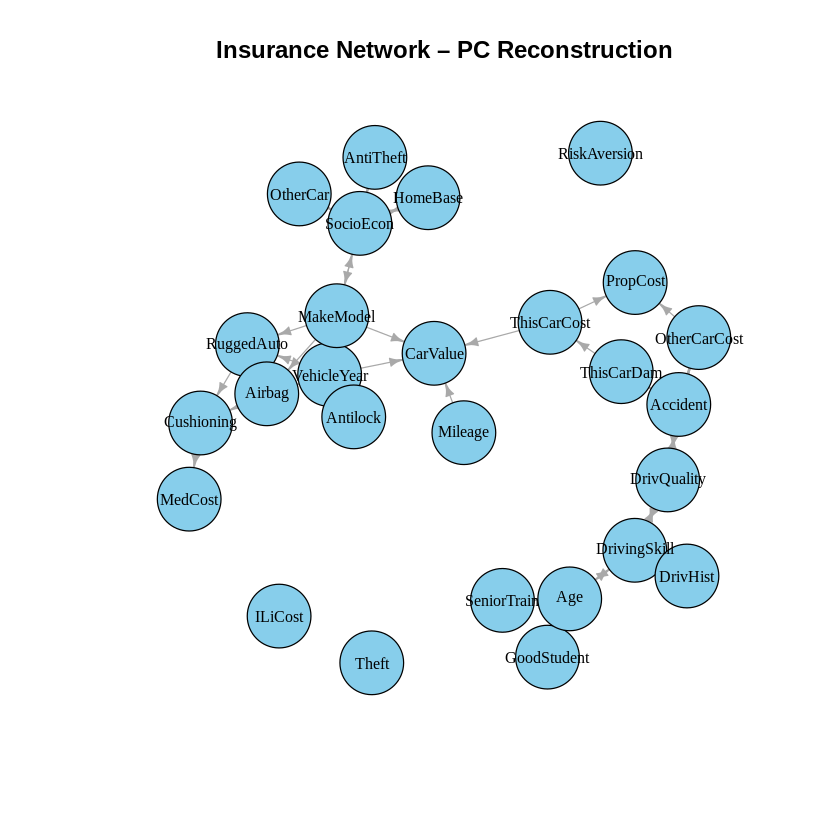

In [105]:
set.seed(123)

plot(g_pc,
     layout = layout_with_fr(g_pc),   # Layout de Fruchterman-Reingold
     vertex.color = "skyblue",
     vertex.frame.color = "black",
     vertex.size = 25,
     vertex.label.color = "black",
     vertex.label.cex = 0.8,
     edge.arrow.size = 0.5,
     edge.color = "darkgray",
     main = "Insurance Network – PC Reconstruction")


## **2.4 Calcul de TP / FP / FN + Precision / Recall / Fscore**

Cette partie consiste à extraire les matrices d’adjacence du graphe vrai (`A_true`) et du graphe PC (`A_pc`), construit leurs **squelettes symétriques** (`S_true`, `S_pc`) pour ignorer l’orientation, puis calcule le nombre de **vrais positifs (TP)**, **faux positifs (FP)** et **faux négatifs (FN)** en comparant les squelettes, en divisant par deux pour ne pas compter deux fois les arêtes symétriques.


In [107]:
A_true <- bnlearn::amat(ground_truth_model)   # matrice ground truth
A_pc   <- bnlearn::amat(bn_fit)            # matrice PC reconstruite


S_true <- (A_true + t(A_true)) > 0    # squelette vrai
S_pc   <- (A_pc   + t(A_pc)) > 0      # squelette PC

TP <- sum(S_pc & S_true) / 2   # /2 car matrices symétriques
FP <- sum(S_pc & !S_true) / 2
FN <- sum(!S_pc & S_true) / 2

TP; FP; FN

[1] 1

[1] 27

[1] 51

In [108]:
precision <- TP / (TP + FP)
recall    <- TP / (TP + FN)
fscore    <- 2 * (precision * recall) / (precision + recall)

precision
recall
fscore

[1] 0.03571429

[1] 0.01923077

[1] 0.025

### **Analyse de l'incohérence des précisions**
L’incohérence dans ce code vient du fait que **les matrices `A_true` et `A_pc` ne sont pas nécessairement alignées sur le même ordre de variables**.

* `bnlearn::amat()` retourne les matrices avec les **noms des lignes et colonnes dans l’ordre interne du réseau**, qui peut différer entre le modèle de vérité (`ground_truth_model`) et le modèle PC (`bn_fit`).
* Si les ordres sont différents, comparer directement `S_true` et `S_pc` va **associer des variables différentes**, ce qui fausse complètement le calcul de TP, FP et FN.

**En conséquence :** certaines arêtes peuvent être comptées comme TP ou FP alors qu’elles ne correspondent pas aux mêmes nœuds, rendant les métriques invalides.

✅ La correction consiste à **réaligner explicitement les colonnes et lignes de `A_pc` sur l’ordre de `A_true`** avant de construire les squelettes :

```r
noms_ordre <- rownames(A_true)
A_pc_aligned <- A_pc[noms_ordre, noms_ordre]
```

Ensuite, on peut construire les squelettes et calculer TP, FP, FN de manière fiable.


### **Stratégie de correction**

>La stratégie ( pour modérer les biais de calcul des performances ) consiste à aligner d’abord les matrices d’adjacence du graphe vrai et du graphe PC pour respecter le même ordre de variables, puis à construire leurs squelettes symétriques pour ignorer l’orientation des arêtes. Ensuite, on compare ces squelettes pour compter les vrais positifs (TP), faux positifs (FP) et faux négatifs (FN), et on en déduit les métriques classiques de performance : Précision, Rappel et F1-score, en sécurisant les divisions pour éviter les valeurs indéfinies.

In [116]:
# --- MATRICE VÉRITÉ ---
matrice_adj <- bnlearn::amat(ground_truth_model)   # Ground truth

# --- MATRICE PC ---
amat_pc <- bnlearn::amat(bn_fit)

# 1. Ordre des variables selon la vérité
noms_ordre <- rownames(matrice_adj)

# 2. Ré-alignement
amat_pc_aligned <- amat_pc[noms_ordre, noms_ordre]

# 3. Squelettes
skel_true <- pmax(matrice_adj, t(matrice_adj))
skel_pc   <- pmax(amat_pc_aligned, t(amat_pc_aligned))

# 4. TP / FP / FN / TN
TP_pc <- sum(skel_true == 1 & skel_pc == 1) / 2
FP_pc <- sum(skel_pc == 1 & skel_true == 0) / 2
FN_pc <- sum(skel_pc == 0 & skel_true == 1) / 2
TN_pc <- sum(skel_pc == 0 & skel_true == 0) / 2   # ajout des vrais négatifs

# 5. Métriques
prec_pc <- if ((TP_pc + FP_pc) > 0) { TP_pc / (TP_pc + FP_pc) } else { 0 }
rec_pc  <- if ((TP_pc + FN_pc) > 0) { TP_pc / (TP_pc + FN_pc) } else { 0 }
f1_pc   <- if ((prec_pc + rec_pc) > 0) { 2 * (prec_pc * rec_pc) / (prec_pc + rec_pc) } else { 0 }

# 6. Affichage
cat("--- RÉSULTATS CORRIGÉS (PC – Squelette) ---\n")
cat("Vrais Positifs (TP)  :", TP_pc, "\n")
cat("Faux Positifs (FP)   :", FP_pc, "\n")
cat("Faux Négatifs (FN)   :", FN_pc, "\n")
cat("Vrais Négatifs (TN)  :", TN_pc, "\n")
cat("-------------------------------------------\n")
cat("Précision :", round(prec_pc, 3), "\n")
cat("Rappel    :", round(rec_pc, 3), "\n")
cat("F-score   :", round(f1_pc, 3), "\n")

--- RÉSULTATS CORRIGÉS (PC – Squelette) ---
Vrais Positifs (TP)  : 28 
Faux Positifs (FP)   : 0 
Faux Négatifs (FN)   : 24 
Vrais Négatifs (TN)  : 312.5 
-------------------------------------------
Précision : 1 
Rappel    : 0.538 
F-score   : 0.7 


### **Analyse des performances du modèle PC (Squelette)**

* **Précision = 1.00 (parfaite)**

La précision parfaite indique que **toutes les arêtes détectées par l’algorithme PC sont vraiment des arêtes**.
Autrement dit, le modèle ne génère **aucune fausse relation** (FP = 0).

Ce comportement peut être dû au seuil α **faible**, ce qui rend les tests d’indépendance plus stricts :
le modèle ne propose une arête que lorsqu’il est très confiant.

* **Rappel = 0.538 (faible à modéré)**

Le rappel indique que le modèle ne récupère qu’environ **53%** de la structure réelle du réseau.

il **manque quasiment la moitié des dépendances** existantes dans la vérité terrain (FN = 24).

Le PC est par conséquent **trop conservateur** :
il privilégie l’absence de faux positifs au prix de nombreux faux négatifs.

* **F-score = 0.70**

Le F-score qui combine précision et rappel montre une performance **correcte mais loin d’être optimale**.
Le score est tiré vers le haut par la précision parfaite mais limité par le rappel insuffisant.

# **Conclusion globale**

L’algorithme PC, dans cette configuration :

* **fait très peu d’erreurs lorsqu’il détecte une arête** : Ceci se justifie par l'excellente précision que nous avons obtenue.
* **La problématique valeur du `recall` nous montre que le modèle PC n’arrive pas à capturer l’ensemble de la structure vraie**

On est donc face à un modèle **hautement spécifique mais peu sensible**.


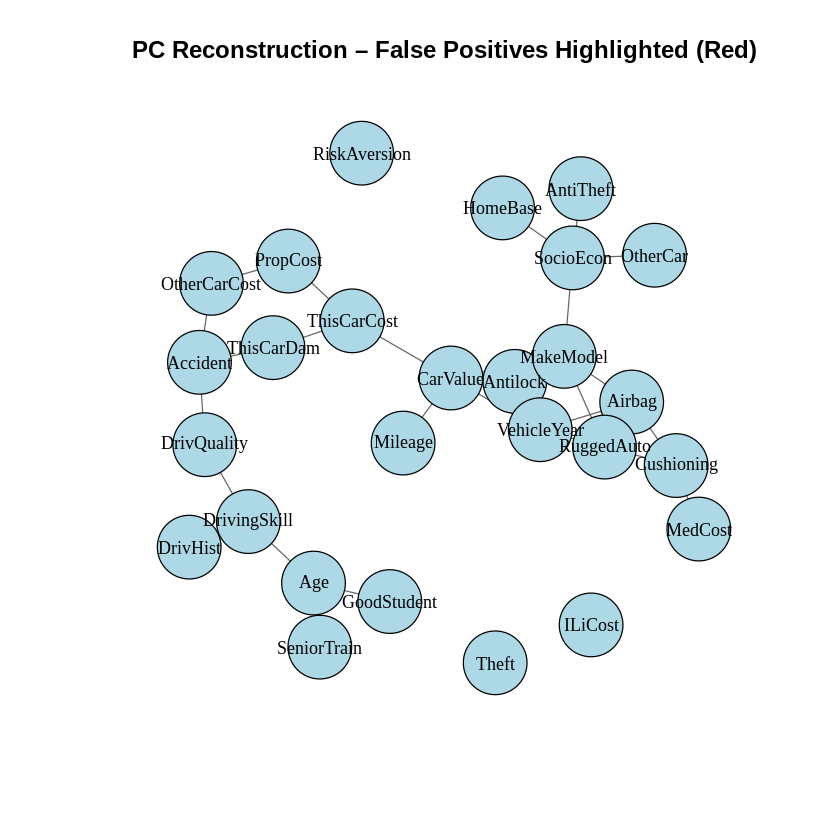

In [115]:
# Graphe PC (squelette, non orienté)
g_pc <- graph_from_adjacency_matrix(
  skel_pc,
  mode = "undirected",
  diag = FALSE
)

# On rétablit les noms des nœuds
V(g_pc)$name <- noms_ordre

# Détection des FP (false positives)
FP_matrix <- (skel_pc == 1 & skel_true == 0)

# Extract edge list from the graph
edges_list <- as_edgelist(g_pc)

# Vector pour stocker la couleur de chaque arête
edge_colors <- rep("grey40", nrow(edges_list))   # par défaut : gris

# Boucle pour colorier les FP
for (i in seq_len(nrow(edges_list))) {
  n1 <- edges_list[i, 1]
  n2 <- edges_list[i, 2]

  if (FP_matrix[n1, n2] == TRUE) {
    edge_colors[i] <- "red"   # FP en rouge
  }
}

E(g_pc)$color <- edge_colors
E(g_pc)$width <- ifelse(edge_colors == "red", 3, 1)  # FP plus épaisses
set.seed(123)

plot(g_pc,
     layout = layout_with_fr(g_pc),
     vertex.color = "lightblue",
     vertex.size = 25,
     vertex.label.color = "black",
     vertex.label.cex = 0.9,
     edge.color = E(g_pc)$color,
     edge.width = E(g_pc)$width,
     main = "PC Reconstruction – False Positives Highlighted (Red)"
)

### **Recommandations**

* Afin d'améliorer la fiabilité des arêtes détectées (précision élevée) : conserver un alpha faible.
Ceci aura pour effet de limiter les faux positifs au prix de rater certaines arêtes. Le graphe reconstruit serait alors partiel mais très fiable.

* Pour maximiser la détection des arêtes (rappel élevé) : Nous devons utiliser un seuil alpha plus élevé, ceci rendra le test d’indépendance moins strict et permettra de détecter davantage d’arêtes. Cette approche augmente le nombre de vrais positifs mais peut générer plus de faux positifs.
Compromis entre rappel et précision : tester plusieurs valeurs de alpha (par exemple 0.01, 0.05, 0.1)

